# 2. iCAPS Timecourses' statistics

In [1]:
from src import *

import scipy
import numpy as np
from matplotlib import cm
from scipy.optimize import linear_sum_assignment

In [648]:
def compute_costmatrix(A,B):
    """
    Compute distance matrix between high-dimensional points
    """
    ret = np.zeros((len(A),len(B)))
    for k in range(len(A)):
        for j in range(len(B)):
            ret[k,j] = (A[k] - B[j])**2
                
    return ret

## Table of Contents
- [iCAPS Statistics](#emotion)
    - Group
    - Synchro

## Description

After being given set of temporally overlapping spatial components (iCAPS) we look into the corresponding timecourses. We then extract first level statistics of such timecourses matching icaps.

GOAL: Extract relevant statistics of iCAPS apparition (fixed number of iCAPS being 20)

In [795]:
root = '/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/'
ids = [file for file in os.listdir(root) if 'sub' in file]

clust_roots = ['iCAPs_results/iCAPS_Emo_Movies_{}_Alpha_5_95_Fraction_0DOT05/'.format(_id) for _id in ids]
ncaps = 20
N_films = 15
# tc_dct = loadmat(root + clust_roots[4] + 'K_20_Dist_cosine_Folds_10/TC_1DOT4.mat')
# tc_stats_dct = loadmat(root + clust_roots[4] + 'K_20_Dist_cosine_Folds_10/TC_stats_1DOT4.mat')

In [339]:
# # ids = [file for file in os.listdir(root) if 'sub' in file]

# # list all pathings
# _dir = "/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/"

# _all = []
# for ID in ids:
#     try :
#         o_f = os.path.join(_dir,f"{ID}/**/*.feat/filtered_func_data_res.nii.gz")
#         o_f = glob.glob(o_f, recursive=True)
#         for k in range(len(o_f)):
#             _all.append('/'.join(o_f[k].split('/')[:-1]) +'/')
#         print(o_f)
#     except:
#         print("Something went wrong with file reading")


# dct = {}
# for I in _all:
#     nifti = nib.load(I+'/filtered_func_data_res.nii.gz')
#     splits = I.split('/')
#     keyA = splits[-4]
#     keyB = splits[-3]
#     keyC = splits[-2].split('_')[-1][:-5]
#     dct[(keyA,keyB,keyC)] = nifti.shape[-1]

# inv_dct = {ID: {} for ID in ids}
# for k in dct:
#     _id,ses,movie = k
#     inv_dct[_id][dct[k]] = movie
    
# save('./resources/run_length.pkl', [dct,inv_dct])

In [125]:
run2length, length2run = load('./resources/run_length.pkl')

In [628]:
timecourse_char = []
labels = []
for idx in range(len(clust_roots)):
    labels.append(ids[idx])
    if os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT4.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT4.mat')['tempChar'][0][0]
    elif os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT2.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT2.mat')['tempChar'][0][0]
    elif os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1.mat')['tempChar'][0][0]
    timecourse_char.append(tmp)
    
timecourse_char = np.stack(timecourse_char)

In [629]:
len(timecourse_char)

14

## Preprocess the timecourses
Many issues arise when combining the various icaps timecourses
- Matching the film names to the rows
- Matching the iCAPS patterns across subjects
- Removing Washer time and only keeping film times
- AGGREGATE all subjects together and match them properly

1. Reordering to alphabetical films + rest order

Hungarian matching to match the length of the timecourses with the name of the film

In [725]:
reordering_films = []
for sidx in range(len(timecourse_char)):
    lengthmatch = length2run[ids[sidx]]
    labels = list(lengthmatch.values())

    ref = timecourse_char[sidx][6][0]
    fmri_trs = [ref[k].shape[1] for k in range(len(ref))]

    B = list(lengthmatch.keys())
    if len(B) == 14: B.append(460) # When Rest is of same length as other series
    if len(labels) == 14: labels +=  ['Rest']

    # Compute the cost matrix
    cost_matrix = compute_costmatrix(fmri_trs, B)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    assignment = [(row, col) for row, col in zip(row_indices, col_indices)]

    current_order = [labels[assignment[k][1]] for k in range(len(fmri_trs))]
    reordering_films.append(np.argsort(current_order))

alph_order = np.sort(current_order)

2. Matching the iCAPS across subjects

In [664]:
assigns = load('./resources/icaps_match_python.pkl')
reordering_icaps = np.asarray(assigns)[:,:,1]

3. Aggregate properly all subjects across their respective statistics
- Also Removing washer time in timecourses statistics from iCAPS

In [718]:
filmnames = list(FILM2DURATION.keys())
fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float).shape[0]

In [760]:
print(alph_order)
print(list(alph_order).index('Rest'))

cropped_len = list(fa_timecourse.values())
# Add rest in 7th position
cropped_len.insert(7,460)

['AfterTheRain' 'BetweenViewings' 'BigBuckBunny' 'Chatter' 'FirstBite'
 'LessonLearned' 'Payload' 'Rest' 'Sintel' 'Spaceman' 'Superhero'
 'TearsOfSteel' 'TheSecretNumber' 'ToClaireFromSonny' 'YouAgain']
7


In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,7))
ax[0].plot(properties[4][0][0][0], label='icaps 1')
ax[0].set_xticklabels([])
ax[1].plot(properties[5][0][0][0], label='icaps 1')
ax[1].set_xticklabels([])
ax[2].plot(properties[5][0][0][1], color='r', label='icaps 2')
for i in range(3):
    ax[i].legend(prop={'size':20}, loc='upper right')

In [765]:
WASH = int(WASH)
agg_prop = {'norm_thresh': [],
            'active': [],
            'nb_coactice_icaps': [],
            'ratio_active': [],
            'ratio_pactive': [],
            'ratio_nactive': [],
            'coupling_count': [],
            'coupling_countratio': [],
            'diffsign_coupling': [],
            'samesign_coupling': []}

for sidx in range(len(timecourse_char)):
    properties = timecourse_char[sidx]
    
    # Basic values of iCAPS timecourses
    tc_norm_thes = properties[4][0]
    tc_active = properties[5][0]
    nb_coactive_time = properties[6][0]
    
    tmp1, tmp2, tmp3 = [], [], []
    for k in range(N_films):
        tmp_order1 = tc_norm_thes[reordering_films[sidx]][k][reordering_icaps[sidx]]
        tmp_order2 = tc_active[reordering_films[sidx]][k][reordering_icaps[sidx]]
        tmp_order3 = nb_coactive_time[reordering_films[sidx]][k]
        
        extended1 = np.concatenate([tmp_order1,np.zeros_like(tmp_order1)],axis=-1)
        extended2 = np.concatenate([tmp_order2,np.zeros_like(tmp_order2)],axis=-1)
        extended3 = np.concatenate([tmp_order3[0],np.zeros_like(tmp_order3[0])],axis=-1)

        # remove washer and crop to match 3FAs
        tmp1.append(extended1[:,WASH:WASH+cropped_len[k]])
        tmp2.append(extended2[:,WASH:WASH+cropped_len[k]])
        tmp3.append(extended3[WASH:WASH+cropped_len[k]])
    
    agg_prop['norm_thresh'].append(tmp1)
    agg_prop['active'].append(tmp2)
    agg_prop['nb_coactice_icaps'].append(tmp3)
    
    # How many times a icaps appear during the movie (as a percentage)
    ratio_active_icaps = properties[13]
    ratio_pactive_icaps = properties[14]
    ratio_nactive_icaps = properties[15]
    
    agg_prop['ratio_active'].append(ratio_active_icaps[reordering_icaps[sidx]][:,reordering_films[sidx]])
    agg_prop['ratio_pactive'].append(ratio_pactive_icaps[reordering_icaps[sidx]][:,reordering_films[sidx]])
    agg_prop['ratio_nactive'].append(ratio_nactive_icaps[reordering_icaps[sidx]][:,reordering_films[sidx]])
    
    # Coupling counts between iCAPS timecourses
    coupling_count = properties[22]
    coupling_countratio = properties[23] # divided by either icaps being activated
    diffsign_coupling_count = properties[29]
    samesign_coupling_count = properties[28]

    agg_prop['coupling_count'].append(coupling_count[reordering_icaps[sidx]][:,reordering_icaps[sidx]][:,:,reordering_films[sidx]])
    agg_prop['coupling_countratio'].append(coupling_countratio[reordering_icaps[sidx]][:,reordering_icaps[sidx]][:,:,reordering_films[sidx]])
    agg_prop['diffsign_coupling'].append(diffsign_coupling_count[reordering_icaps[sidx]][:,reordering_icaps[sidx]][:,:,reordering_films[sidx]])
    agg_prop['samesign_coupling'].append(samesign_coupling_count[reordering_icaps[sidx]][:,reordering_icaps[sidx]][:,:,reordering_films[sidx]])
    # index 24-27 useless and index 30-34 are for jaccard index if needed    

In [824]:
subj_agg_prop = {'norm_thresh': [[] for _ in range(N_films)],
            'active': [[] for _ in range(N_films)],
            'nb_coactice_icaps': [[] for _ in range(N_films)],
            'ratio_active': [[] for _ in range(N_films)],
            'ratio_pactive': [[] for _ in range(N_films)],
            'ratio_nactive': [[] for _ in range(N_films)],
            'coupling_count': [[] for _ in range(N_films)],
            'coupling_countratio': [[] for _ in range(N_films)],
            'diffsign_coupling': [[] for _ in range(N_films)],
            'samesign_coupling': [[] for _ in range(N_films)]}

for fidx in range(N_films):
    for sidx in range(len(timecourse_char)):
        subj_agg_prop['norm_thresh'][fidx].append(agg_prop['norm_thresh'][sidx][fidx])
        subj_agg_prop['active'][fidx].append(agg_prop['active'][sidx][fidx])
        subj_agg_prop['nb_coactice_icaps'][fidx].append(agg_prop['nb_coactice_icaps'][sidx][fidx])
        subj_agg_prop['ratio_active'][fidx].append(agg_prop['ratio_active'][sidx][:,fidx])
        subj_agg_prop['ratio_pactive'][fidx].append(agg_prop['ratio_pactive'][sidx][:,fidx])
        subj_agg_prop['ratio_nactive'][fidx].append(agg_prop['ratio_nactive'][sidx][:,fidx])
        subj_agg_prop['coupling_count'][fidx].append(agg_prop['coupling_count'][sidx][:,:,fidx])
        subj_agg_prop['coupling_countratio'][fidx].append(agg_prop['coupling_countratio'][sidx][:,:,fidx])
        subj_agg_prop['diffsign_coupling'][fidx].append(agg_prop['diffsign_coupling'][sidx][:,:,fidx])
        subj_agg_prop['samesign_coupling'][fidx].append(agg_prop['samesign_coupling'][sidx][:,:,fidx])

In [791]:
# save('./resources/matched_stats_timecourse.pkl',subj_agg_prop)

## iCAPS Statistics

### Statistics to extract from the iCAPS (group level)

- Count of time an iCAPS appears
- Count number of co-pattern of iCAPS 
- Count number of iCAPS appearing as a function of TR
- Count number of an iCAPS appears (in terms of transition, so a continuous icaps is counted as 1 appearance) 

#### Number of simultaneous active iCAPS across films and rest

In [796]:
nb_coactives = [np.asarray(subj_agg_prop['nb_coactice_icaps'][k]).mean(axis=0) for k in range(N_films)]

<Axes: >

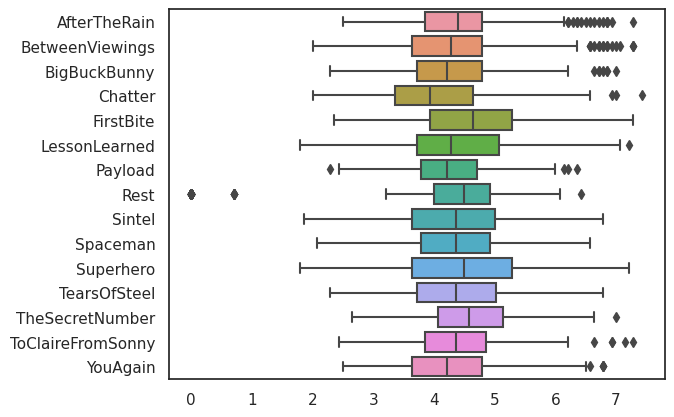

In [812]:
df = {'nb_coactive': np.concatenate(nb_coactives), 
      'moviename': np.concatenate([[fname]*cropped_len[nb] for nb,fname in enumerate(list(alph_order))])}
sns.boxplot(data=df, x="nb_coactive", y="moviename")

#### Ratio of each iCAPS in the timecourse across films and rest
Compare all films aggregated and rest

In [826]:
film_indexes = np.array([n for n in range(N_films) if n!=7])
rest_index = np.array([7])

In [834]:
df1 = {'moviename': ['films', 'rest']}
df2 = {'moviename': ['films', 'rest']}
df3 = {'moviename': ['films', 'rest']}

tmp1 = np.asarray(subj_agg_prop['ratio_active'])
tmp2 = np.asarray(subj_agg_prop['ratio_pactive'])
tmp3 = np.asarray(subj_agg_prop['ratio_nactive'])
for j in range(ncaps):
    df1['icaps{}'.format(j+1)] = [tmp1[film_indexes].mean(axis=0).mean(axis=0)[j]/100]
    df2['icaps{}'.format(j+1)] = [tmp2[film_indexes].mean(axis=0).mean(axis=0)[j]/100]
    df3['icaps{}'.format(j+1)] = [tmp3[film_indexes].mean(axis=0).mean(axis=0)[j]/100]

for j in range(ncaps):
    df1['icaps{}'.format(j+1)] += [tmp1[rest_index].mean(axis=0).mean(axis=0)[j]/100]
    df2['icaps{}'.format(j+1)] += [tmp2[rest_index].mean(axis=0).mean(axis=0)[j]/100]
    df3['icaps{}'.format(j+1)] += [tmp3[rest_index].mean(axis=0).mean(axis=0)[j]/100]
    
df1 = pd.DataFrame.from_dict(df1)
df2 = pd.DataFrame.from_dict(df2)
df3 = pd.DataFrame.from_dict(df3)

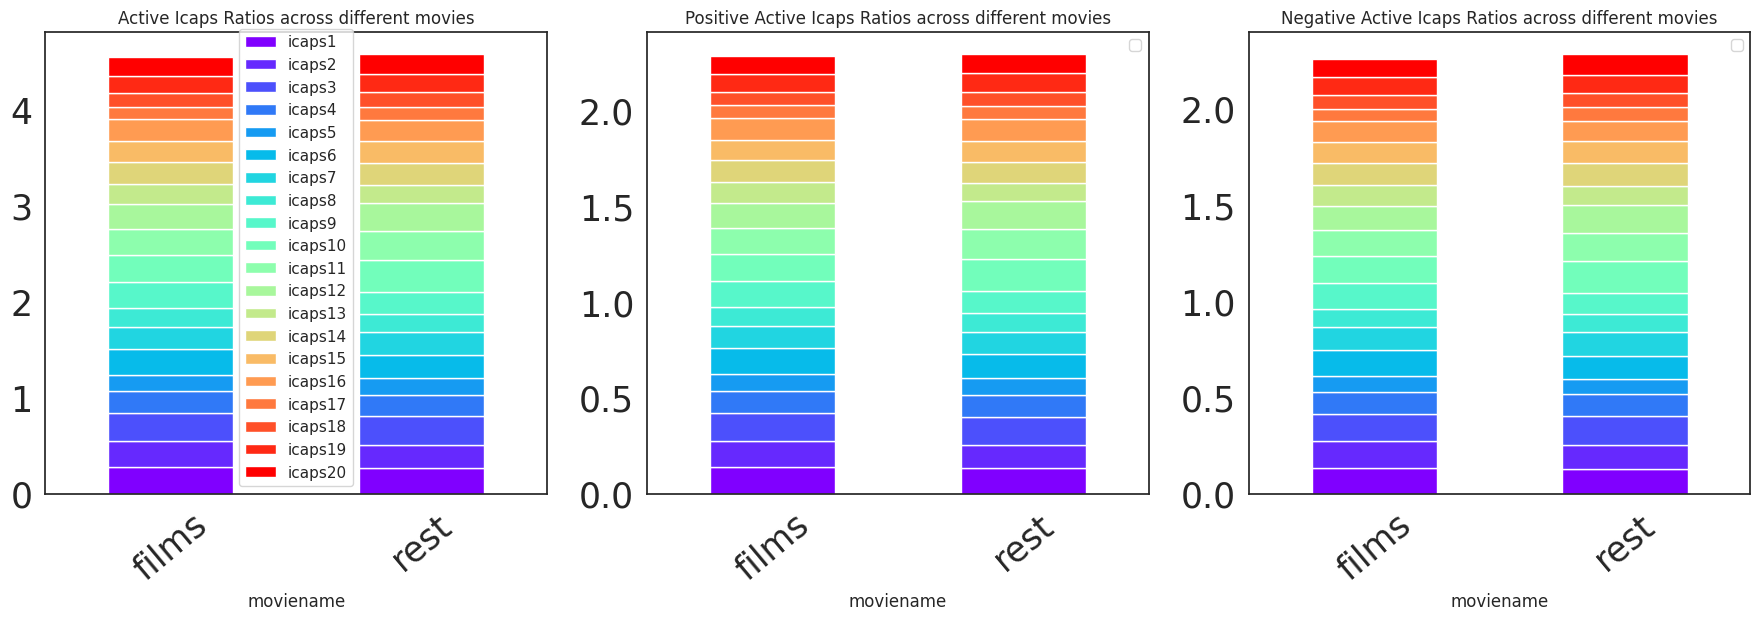

In [845]:
fig, ax = plt.subplots(1,3, figsize=(22,6))
colors = cm.rainbow(np.linspace(0, 1, len(ratio_active_icaps)))
df1.plot.bar(x='moviename', stacked=True, title='Active Icaps Ratios across different movies', 
            ax=ax[0], color=colors, fontsize=25,rot=40)


df2.plot.bar(x='moviename', stacked=True, title='Positive Active Icaps Ratios across different movies', 
            ax=ax[1], color=colors, fontsize=25,rot=40)
ax[1].legend([])

df3.plot.bar(x='moviename', stacked=True, title='Negative Active Icaps Ratios across different movies', 
            ax=ax[2], color=colors, fontsize=25,rot=40)
ax[2].legend([])

#### Coupling of iCAPS in the timecourse across films and rest
Compare all films aggregated and rest

/tmp/ipykernel_158294/592051245.py:4: RuntimeWarning: Mean of empty slice
  ax[0,0].imshow(np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[film_indexes], axis=(0,1)),
/tmp/ipykernel_158294/592051245.py:22: RuntimeWarning: Mean of empty slice
  ax[1,0].imshow(np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[rest_index], axis=(0,1)),


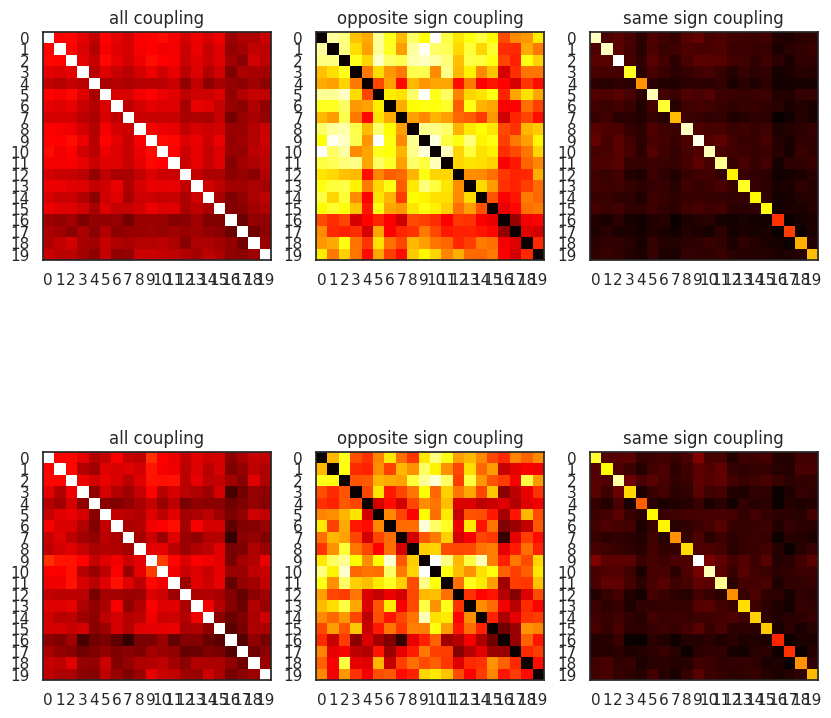

In [865]:
# Add colorbar meaning
# Average coupling on the 15 movies between icaps
fig, ax = plt.subplots(2,3,figsize=(10,10)) 
ax[0,0].imshow(np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[film_indexes], axis=(0,1)), 
               cmap='hot', vmin=0, vmax=0.5)
ax[0,0].set_xticks(np.arange(20)) 
ax[0,0].set_yticks(np.arange(20)) 
ax[0,0].set_title('all coupling')

ax[0,1].imshow(np.nanmean(np.asarray(subj_agg_prop['diffsign_coupling'])[film_indexes], axis=(0,1)),
               cmap='hot')
ax[0,1].set_xticks(np.arange(20)) 
ax[0,1].set_yticks(np.arange(20))
ax[0,1].set_title('opposite sign coupling')

ax[0,2].imshow(np.nanmean(np.asarray(subj_agg_prop['samesign_coupling'])[film_indexes], axis=(0,1)),
               cmap='hot')
ax[0,2].set_xticks(np.arange(20))
ax[0,2].set_yticks(np.arange(20))
ax[0,2].set_title('same sign coupling')

ax[1,0].imshow(np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[rest_index], axis=(0,1)), 
               cmap='hot', vmin=0, vmax=.5)
ax[1,0].set_xticks(np.arange(20)) 
ax[1,0].set_yticks(np.arange(20)) 
ax[1,0].set_title('all coupling')

ax[1,1].imshow(np.nanmean(np.asarray(subj_agg_prop['diffsign_coupling'])[rest_index], axis=(0,1)),
               cmap='hot')
ax[1,1].set_xticks(np.arange(20)) 
ax[1,1].set_yticks(np.arange(20))
ax[1,1].set_title('opposite sign coupling')

ax[1,2].imshow(np.nanmean(np.asarray(subj_agg_prop['samesign_coupling'])[rest_index], axis=(0,1)),
               cmap='hot')
ax[1,2].set_xticks(np.arange(20))
ax[1,2].set_yticks(np.arange(20))
ax[1,2].set_title('same sign coupling')

plt.show()

/tmp/ipykernel_158294/2215356452.py:1: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_158294/2215356452.py:2: RuntimeWarning:

Mean of empty slice



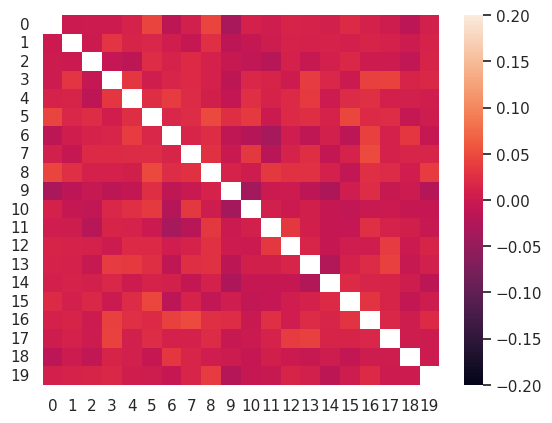

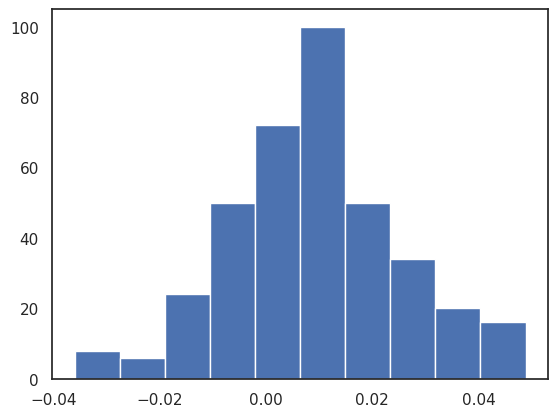

In [1076]:
film_cpratio = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[film_indexes], axis=(0,1))
rest_cpratio = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[rest_index], axis=(0,1))

import seaborn as sns
sns.heatmap(film_cpratio - rest_cpratio, vmin=-0.2, vmax=0.2)
plt.show()
plt.hist((film_cpratio - rest_cpratio).flatten())
plt.show()

In [873]:
film_couplingvector = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[film_indexes], axis=(0,1))
film_couplingvector = film_couplingvector[~np.eye(film_couplingvector.shape[0],dtype=bool)].reshape(film_couplingvector.shape[0],-1)

rest_couplingvector = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[rest_index], axis=(0,1))
rest_couplingvector = rest_couplingvector[~np.eye(rest_couplingvector.shape[0],dtype=bool)].reshape(rest_couplingvector.shape[0],-1)

/tmp/ipykernel_158294/3181374947.py:1: RuntimeWarning: Mean of empty slice
  film_couplingvector = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[film_indexes], axis=(0,1))
/tmp/ipykernel_158294/3181374947.py:4: RuntimeWarning: Mean of empty slice
  rest_couplingvector = np.nanmean(np.asarray(subj_agg_prop['coupling_countratio'])[rest_index], axis=(0,1))


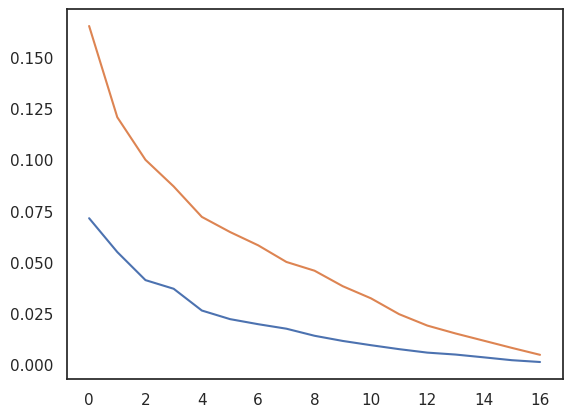

In [883]:
elbow = []
for k in range(2,19):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(film_couplingvector)
    elbow.append(kmeans.inertia_)
plt.plot(elbow)

elbow = []
for k in range(2,19):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(rest_couplingvector)
    elbow.append(kmeans.inertia_)
plt.plot(elbow)

In [886]:
KMeans(n_clusters=4, random_state=0, n_init="auto").fit(film_couplingvector).labels_

array([0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 2, 1, 1, 3, 3],
      dtype=int32)

In [887]:
KMeans(n_clusters=4, random_state=0, n_init="auto").fit(rest_couplingvector).labels_

array([0, 0, 0, 1, 3, 1, 1, 3, 1, 0, 0, 0, 3, 1, 1, 1, 2, 2, 3, 3],
      dtype=int32)

#### Duration of a consecutive iCAPS and number of discontinuous iCAPS

In [922]:
import itertools
def consecutive_onescount(array):
    return [ sum( 1 for _ in group ) for key, group in itertools.groupby( array ) if key ]

In [928]:
counts_df = {'icaps': [], 'counts': [], 'type': []}
duration_df = {'icaps': [], 'duration': [], 'type': []}

for fidx in range(N_films):
    farray = np.asarray(subj_agg_prop['active'][fidx])
    _type = 'rest' if fidx==7 else 'film'
    for sidx in range(len(farray)):
        for capsidx in range(ncaps):
            occurence = consecutive_onescount(farray[sidx][capsidx])
            counts = len(occurence)/len(farray[sidx][capsidx]) # normalized to the length of the films
            counts_df['icaps'] += ['icaps{}'.format(capsidx+1)]
            counts_df['counts'] += [counts]
            counts_df['type'] += [_type]
            
            duration_df['duration'] += list(occurence)
            duration_df['icaps'] += len(list(occurence)) * ['icaps{}'.format(capsidx+1)]
            duration_df['type'] += len(list(occurence)) * [_type]
            
counts_df = pd.DataFrame.from_dict(counts_df)
duration_df = pd.DataFrame.from_dict(duration_df)

/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps9_film vs. icaps9_rest: Custom statistical test, P_val:2.948e-02
icaps6_film vs. icaps6_rest: Custom statistical test, P_val:4.947e-02


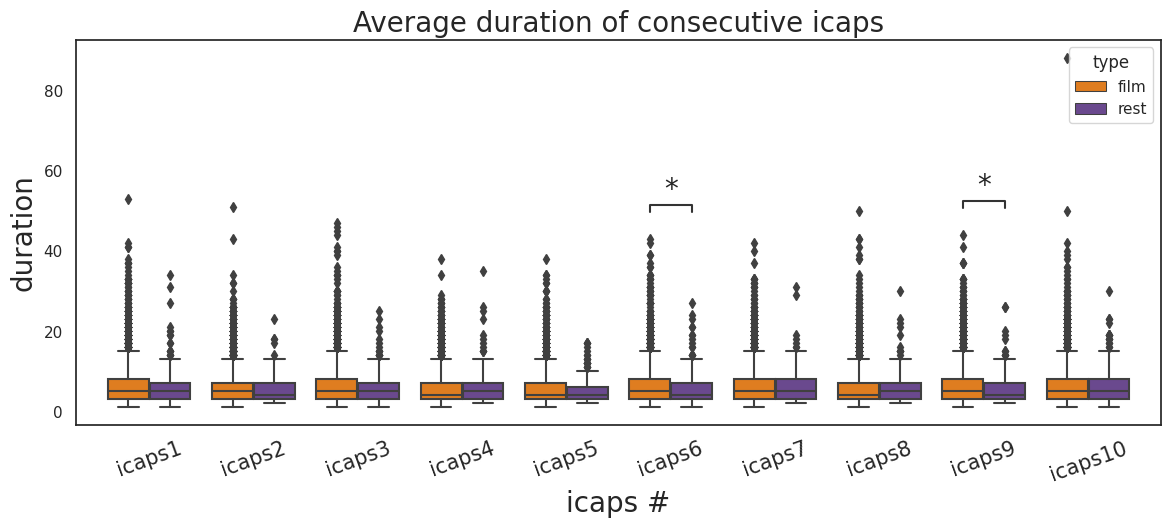

/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps12_film vs. icaps12_rest: Custom statistical test, P_val:4.120e-02
icaps13_film vs. icaps13_rest: Custom statistical test, P_val:1.132e-02


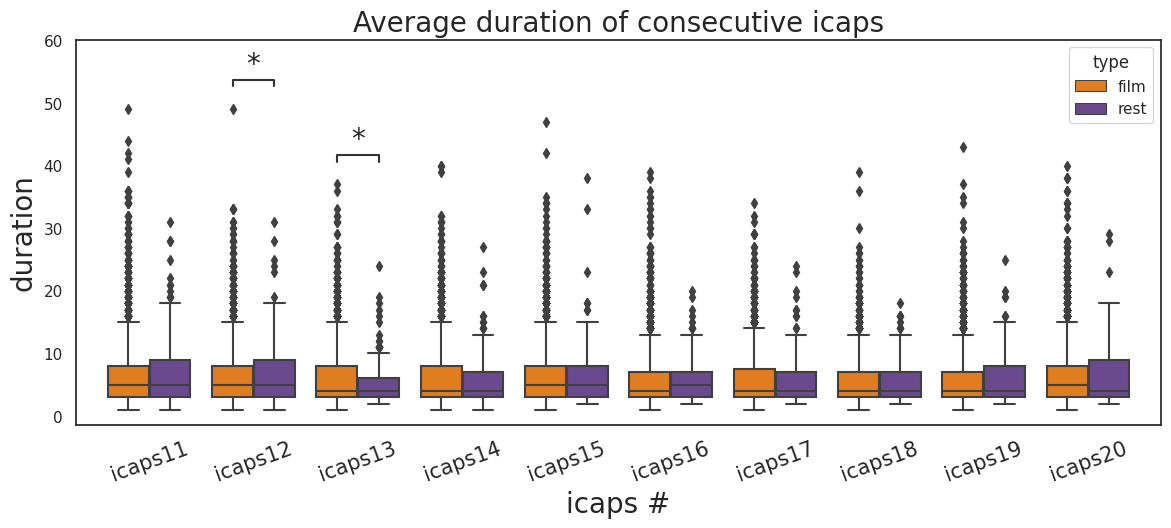

In [935]:
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set_theme(style='white')

arr1 = ['icaps{}'.format(k) for k in range(1,11)]
arr2 = ['icaps{}'.format(k) for k in range(11,21)]

tmp_psy = [arr1,arr2]
for i in range(2):
    plt.figure(figsize=(14,5))

    p = sns.boxplot(x="icaps", y="duration", data=duration_df[duration_df['icaps'].isin(tmp_psy[i])], hue="type",
                  color="r", dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

    plotting_parameters = {'data':    duration_df[duration_df['icaps'].isin(tmp_psy[i])],'x':'icaps',
                           'y':'duration','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                     ,sns.color_palette("Paired")[9]])}
    
    pvalues = []
    pairs = []
    for psy_p in tmp_psy[i]:
        tmp = duration_df[duration_df['icaps'] == psy_p]
        arr1 = np.nan_to_num(list(tmp[tmp['type']=='film']['duration']))
        arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['duration']))

        # paired t-test
        pval = stats.ttest_ind(arr1, arr2).pvalue

        # print((psy_p,'films'), (psy_p, 'films'), pval)
        if pval >= 0.05: continue
        pvalues.append(pval)
        pairs.append(((psy_p,'film'), (psy_p, 'rest')))

    annotator = Annotator(p, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(loc='inside', fontsize=20)
    annotator.annotate()
    
    p.set_ylabel('duration', fontsize=20)
    p.set_xlabel('icaps #', fontsize=20)
    p.set_xticklabels(tmp_psy[i], fontsize=15,rotation=20)

    plt.title("Average duration of consecutive icaps", fontsize=20)
    plt.show()

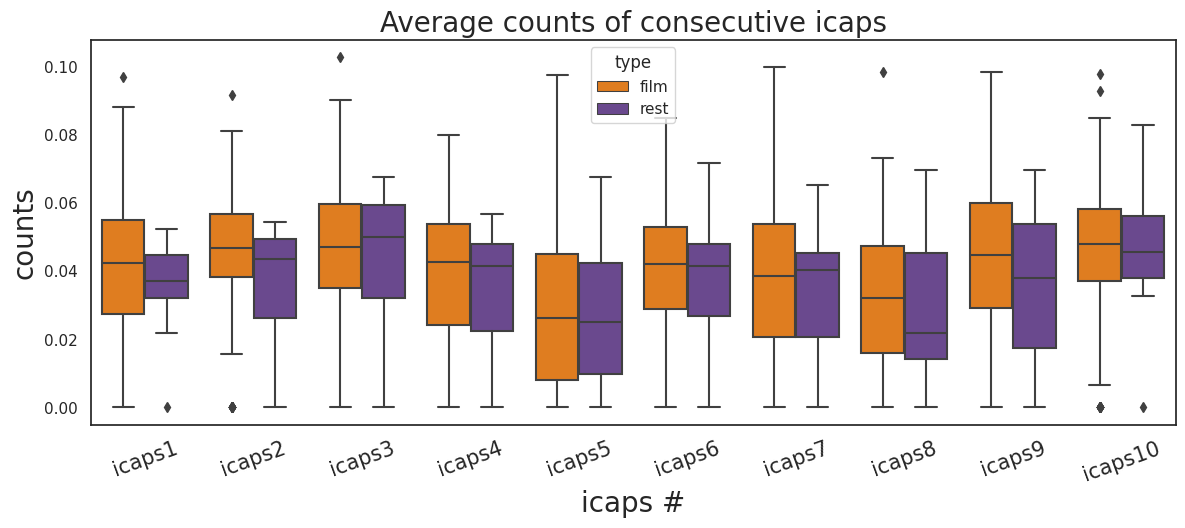

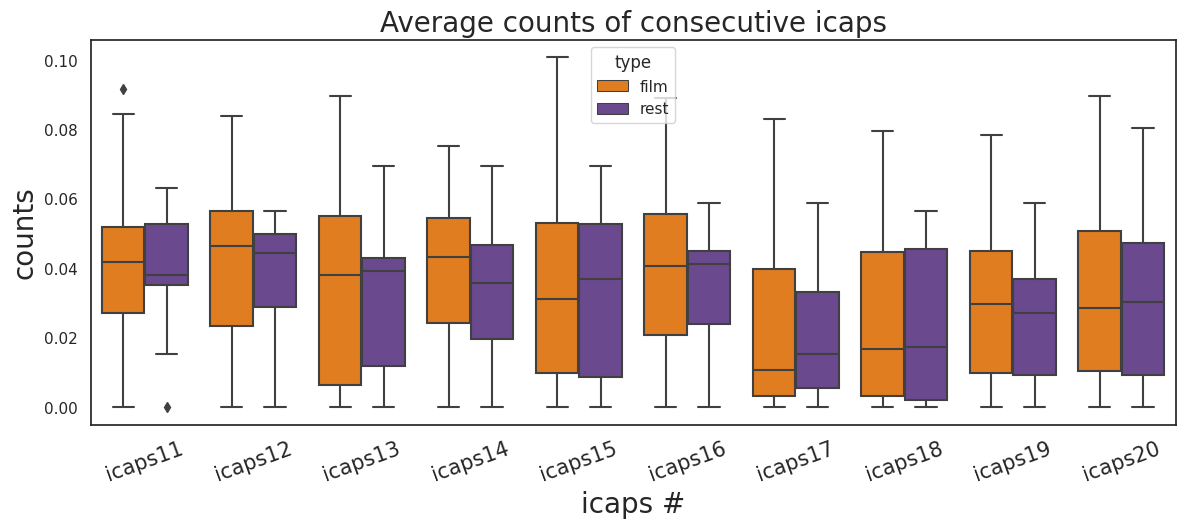

In [939]:
sns.set_theme(style='white')

arr1 = ['icaps{}'.format(k) for k in range(1,11)]
arr2 = ['icaps{}'.format(k) for k in range(11,21)]

tmp_psy = [arr1,arr2]
for i in range(2):
    plt.figure(figsize=(14,5))

    p = sns.boxplot(x="icaps", y="counts", data=counts_df[counts_df['icaps'].isin(tmp_psy[i])], hue="type",
                  color="r", dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

    plotting_parameters = {'data':    counts_df[counts_df['icaps'].isin(tmp_psy[i])],'x':'icaps',
                           'y':'counts','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                     ,sns.color_palette("Paired")[9]])}
    
    pvalues = []
    pairs = []
    for psy_p in tmp_psy[i]:
        tmp = counts_df[counts_df['icaps'] == psy_p]
        arr1 = np.nan_to_num(list(tmp[tmp['type']=='film']['counts']))
        arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['counts']))

        # paired t-test
        pval = stats.ttest_ind(arr1, arr2).pvalue

        # print((psy_p,'films'), (psy_p, 'films'), pval)
        if pval >= 0.05: continue
        pvalues.append(pval)
        pairs.append(((psy_p,'film'), (psy_p, 'rest')))
    if pairs != []:
        annotator = Annotator(p, pairs, **plotting_parameters)
        annotator.set_pvalues(pvalues)
        annotator.configure(loc='inside', fontsize=20)
        annotator.annotate()
    
    p.set_ylabel('counts', fontsize=20)
    p.set_xlabel('icaps #', fontsize=20)
    p.set_xticklabels(tmp_psy[i], fontsize=15,rotation=20)

    plt.title("Average counts of consecutive icaps", fontsize=20)
    plt.show()

### Statistics to extract from the iCAPS taken subjects cohesion

- Synchronization of subjects (a matched iCAPS appear same time for subjects?)
- Compute a probability series of an iCAPS to appear at a given point given the population
    - Compare counts distribution of iCAPS across subjects
- State transition (how often?)

#### Synchronization of subjects

In [940]:
def betweensubj_dist_time(film):
    """
    Compute between subjects distance over a timecourse
    """
    centroid_time = film.mean(axis=0)
    distance2centroid_time = ((film - centroid_time) ** 2).sum(axis=1)
    avg_distance2centroid_time = distance2centroid_time.mean(axis=0)
    return avg_distance2centroid_time

In [988]:
synchro_course = []
for fidx in range(N_films):
    if fidx == 7:
        synchro_course.append(betweensubj_dist_time(np.asarray(subj_agg_prop['norm_thresh'][fidx][:380])))
    else:
        synchro_course.append(betweensubj_dist_time(np.asarray(subj_agg_prop['norm_thresh'][fidx])))

In [990]:
films_synchro = np.concatenate([synchro_course[k] for k in film_indexes])
rest_synchro = synchro_course[7][:380]

/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0_film vs. 0_rest: Custom statistical test, P_val:5.944e-08


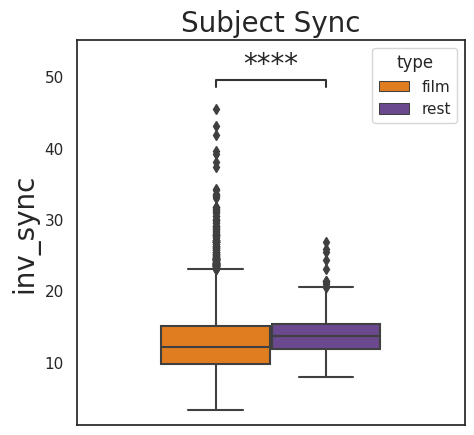

In [993]:
cur_df = {'dummy': [], 'inv_sync': list(films_synchro) + list(rest_synchro),
          'type': len(list(films_synchro)) * ['film'] + len(list(rest_synchro)) * ['rest']}
cur_df['dummy'] = len(cur_df['type']) * [0]
cur_df = pd.DataFrame.from_dict(cur_df)

sns.set_theme(style='white')
plt.figure(figsize=(5,5))

p = sns.boxplot(x="dummy", y="inv_sync", data=cur_df, hue="type",
                  color="r", dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

plotting_parameters = {'data':    cur_df,'x':'dummy',
                           'y':'inv_sync','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                     ,sns.color_palette("Paired")[9]])}
    
pvalues = []
pairs = []
arr1 = np.nan_to_num(list(cur_df[cur_df['type']=='film']['inv_sync']))
arr2 = np.nan_to_num(list(cur_df[cur_df['type']=='rest']['inv_sync']))

# paired t-test
pval = stats.ttest_ind(arr1, arr2).pvalue
if pval <= 0.05: 
    pvalues.append(pval)
    pairs.append(((0,'film'), (0, 'rest')))
if pairs != []:
    annotator = Annotator(p, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(loc='inside', fontsize=20)
    annotator.annotate()
    
p.set_ylabel('inv_sync', fontsize=20)
p.set_xlabel('', fontsize=20)
p.set_xticklabels([], fontsize=15,rotation=20)

plt.title("Subject Sync", fontsize=20)
plt.show()

#### Group probability series

In [999]:
proba_course = [np.asarray(np.abs(subj_agg_prop['active'][fidx])).mean(axis=0) for fidx in range(N_films)]

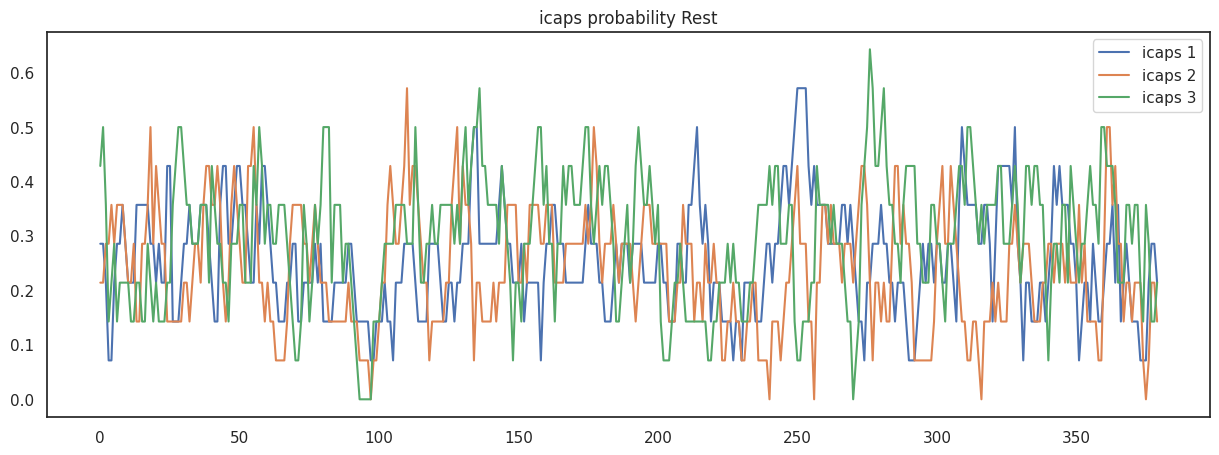

In [1000]:
plt.figure(figsize=(15,5))
plt.title('icaps probability Rest')
for k in range(3):
    plt.plot(proba_course[7][k][:380], label='icaps {}'.format(k+1))
plt.legend()

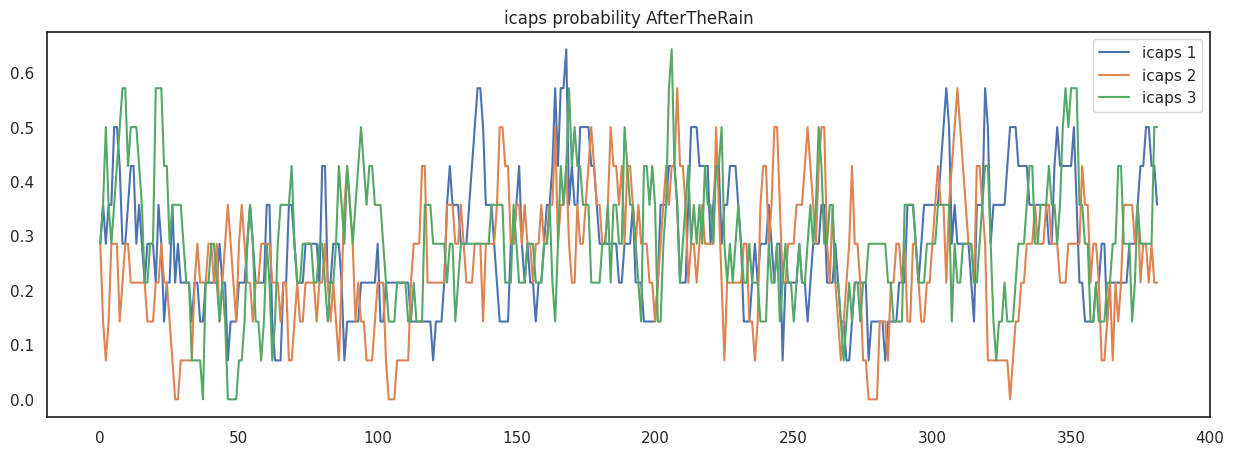

In [1025]:
plt.figure(figsize=(15,5))
plt.title('icaps probability {}'.format(alph_order[0]))
for k in range(3):
    plt.plot(proba_course[0][k], label='icaps {}'.format(k+1))
    
plt.legend()

#### Counts Distribution

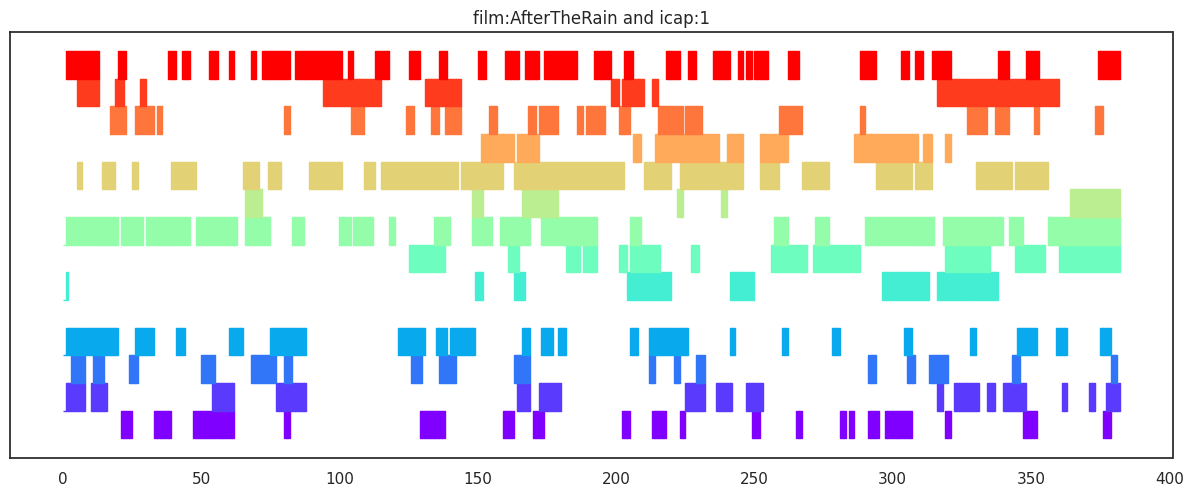

In [1051]:
tmp = np.abs(np.asarray(np.abs(subj_agg_prop['active'][0]))[:,0])
for k in range(len(tmp)):
    tmp[k] *= (k+1)
    
color = cm.rainbow(np.linspace(0, 1, len(tmp)))

data = tmp
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect(10)

for y, row in enumerate(data):
    for x, col in enumerate(row):
        x1, y1, y2 = [x, x+1], np.array([y, y]), y1+1
        if col >= 1:
            plt.fill_between(x1, y1, y2=y2, color=color[y])

ax.set_title('film:{} and icap:{}'.format(alph_order[0], 1))
plt.show()

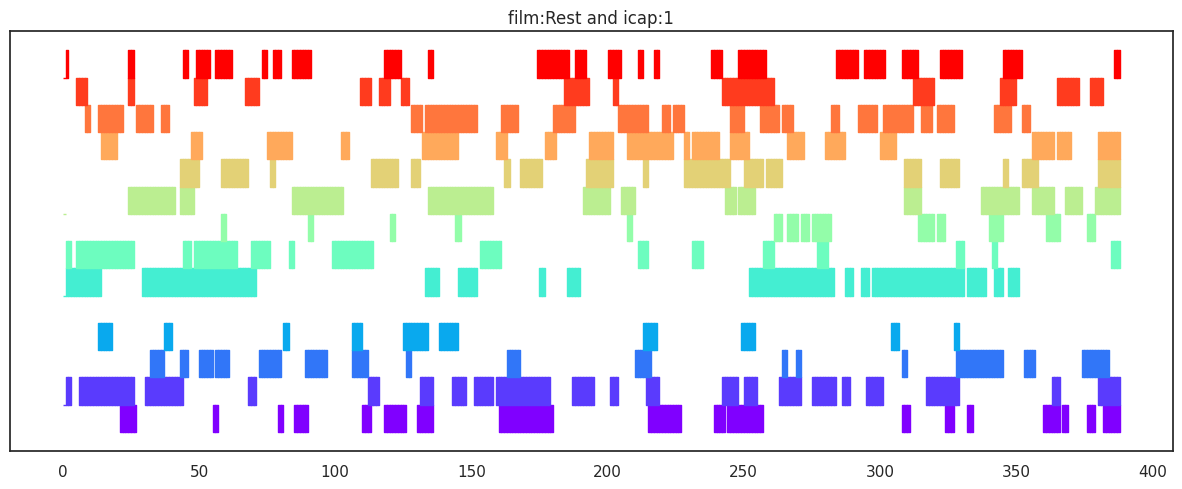

In [1052]:
tmp = np.abs(np.asarray(np.abs(subj_agg_prop['active'][7]))[:,0])
for k in range(len(tmp)):
    tmp[k] *= (k+1)
    
color = cm.rainbow(np.linspace(0, 1, len(tmp)))

data = tmp
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect(10)

for y, row in enumerate(data):
    for x, col in enumerate(row):
        x1, y1, y2 = [x, x+1], np.array([y, y]), y1+1
        if col >= 1:
            plt.fill_between(x1, y1, y2=y2, color=color[y])

ax.set_title('film:{} and icap:{}'.format(alph_order[7], 1))
plt.show()

#### State Transition

In [1002]:
def compute_states_dynamism(states, metric='hammer'):
    """ 
    Compute the change of states over time
    
    Input: states (NxT) N being the dimension of the state and T being the number of timepoints
    Return: scalar quantifiying changes over time
    """
    
    diff_states = states[:,1:] - states[:,:-1]
    if metric == 'hammer':
        ret = np.abs(diff_states).sum(axis=0)

    elif metric == 'euclidean':
        ret = np.sqrt((diff_states**2).sum(axis=0))
    
    return ret

In [1014]:
transition_course = []
for fidx in range(N_films):
    if fidx == 7:
        tmp = compute_states_dynamism(np.asarray(subj_agg_prop['norm_thresh'][fidx][:380]).mean(axis=0))
    else:
        tmp = compute_states_dynamism(np.asarray(subj_agg_prop['norm_thresh'][fidx]).mean(axis=0))
    transition_course.append(tmp)

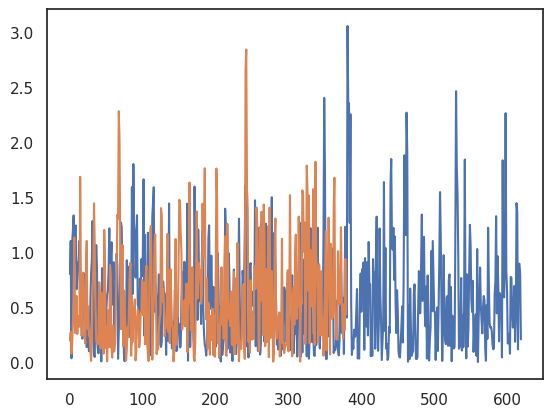

In [1059]:
plt.plot(np.abs(np.diff(transition_course[1])))
plt.plot(np.abs(np.diff(transition_course[7]))[:380])

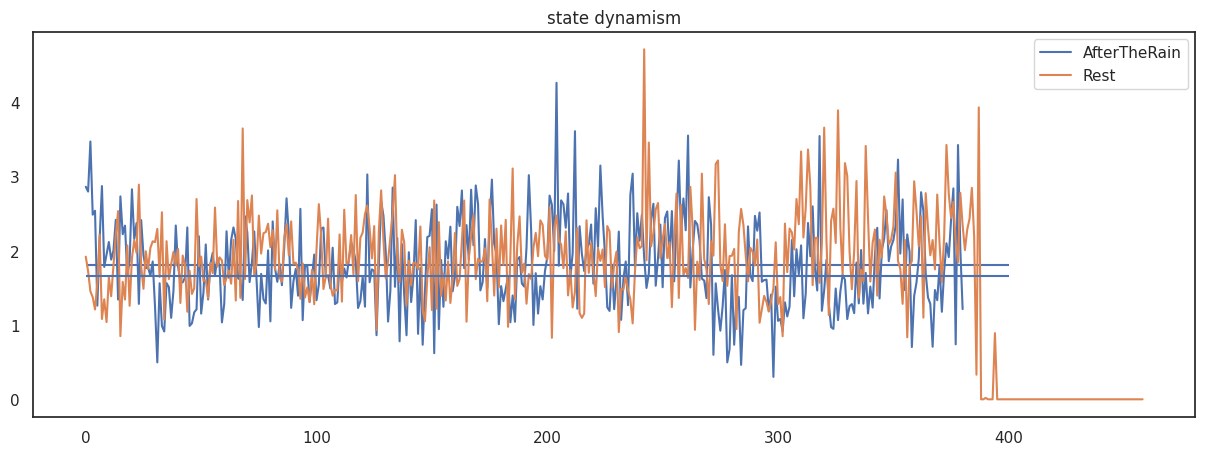

In [1020]:
plt.figure(figsize=(15,5))
plt.title('state dynamism')
for k in [0,7]:
    plt.plot(transition_course[k], label='{}'.format(alph_order[k]))
    plt.hlines(y=transition_course[k].mean(), xmin=0, xmax=400)
plt.legend()